# Utility

In [1]:
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu  # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt

import numba
from joblib import Parallel, delayed  # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation
import tempfile
import gmsh
import meshio
import itertools
import shutil  # file copying
import networkx as nx # graph representation
import os

from lxml import etree
from matplotlib.colors import to_hex, to_rgba

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################
from robot_utils import *
import robot_utils
# help(robot_utils)

#############################################################
robot_folder = "../../mesh/v9.0/"
part_names = ["body","hip","shank_front","shank_back","thigh"]

open3d :0.12.0
trimesh:3.9.8
numba  :0.53.0


In [2]:
########## discretization parameters ##############
# radius_poisson = float(10) # radius for the poisson sampling
radius_poisson = float(15) # radius for the poisson sampling
radius_knn = radius_poisson*np.sqrt(3)*1.0
min_radius = radius_poisson*0.5
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
max_nn = int(28)
print(radius_knn)

half_joint_overlap = radius_poisson * 0
joint_overlap = half_joint_overlap*2
print(f"joint_overlap:{joint_overlap}")

# general argument
gmsh_args = [
        ("Mesh.Algorithm", 6), # 2D mesh algorithm (1: MeshAdapt, 2: Automatic, 3: Initial mesh only, 5: Delaunay, 6: Frontal-Delaunay, 7: BAMG, 8: Frontal-Delaunay for Quads, 9: Packing of Parallelograms)
        ("Mesh.Algorithm3D", 10), # 3D mesh algorithm (1: Delaunay, 3: Initial mesh only, 4: Frontal, 7: MMG3D, 9: R-tree, 10: HXT)
        ("Mesh.MeshSizeExtendFromBoundary", 0),# Extend computation of mesh element sizes from the boundaries into the interior (for 3D Delaunay, use 1: longest or 2: shortest surface edge length)
        ("Mesh.MeshSizeFromPoints", 0),# Compute mesh element sizes from values given at geometry points, defualt:1
        ("Mesh.MeshSizeFromCurvature", 0),# Automatically compute mesh element sizes from curvature,defult:0
        ("Mesh.OptimizeNetgen",0), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
        ("Mesh.OptimizeThreshold",0.5), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
#         ("Mesh.AllowSwapAngle",30), # Threshold angle (in degrees) between faces normals under which we allow an edge swap
        ("Mesh.VolumeEdges",1), # Display edges of volume mesh
        ("Mesh.VolumeFaces",0), # Display faces of volume mesh
        ("Mesh.SurfaceFaces",1), # Display faces of surface mesh?
        ("Mesh.Smoothing",8), # Number of smoothing steps applied to the final mesh
#         ("Mesh.SmoothNormals",0), # Smooth the mesh normals? default 0
        ("Mesh.Binary",1), # Write mesh files in binary format (if possible)
        ("Mesh.MinimumCirclePoints",0), # Minimum number of nodes used to mesh circles and ellipses
        ("Mesh.MinimumCurvePoints",0), # Minimum number of points used to mesh curves other than lines, circles and ellipses
        ("Mesh.MinimumElementsPerTwoPi",0), # Minimum number of elements per 2 * Pi radians when the mesh size is adapted to the curvature    
        ("Mesh.RefineSteps",20), # Number of refinement steps in the MeshAdapt-based 2D algorithms, default:10
    
#         ("Geometry.Tolerance",radius_poisson*0.5),# Geometrical tolerance,default:1e-8
        ("Geometry.OCCFixDegenerated",1), # Fix degenerated edges/faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
        ("Geometry.OCCFixSmallEdges",1), # Fix small edges when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
        ("Geometry.OCCFixSmallFaces",1), # Fix small faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
#         ("Geometry.OCCSewFaces",1), # Sew faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel
#         ("Geometry.OCCBoundsUseStl",1), # Use STL mesh for computing bounds of OpenCASCADE shapes (more accurate, but slower)

        ("General.Verbosity",0), # Level of information printed during processing (0: no information), default:5
        ("General.Terminal",0), # Should information be printed on the terminal (if available)
#         ("Mesh.RandomSeed",0), # Seed of pseudo-random number generator
#         ("Mesh.QualitySup",0.5), # Only display elements whose quality measure is smaller than QualitySup
]

# 2D specific argument
gmsh_args_2d = [
        ("Mesh.MeshSizeMin", radius_poisson*1.4),
        ("Mesh.MeshSizeMax", radius_poisson*1.4),
] 

# 3D specific argument
gmsh_args_3d = [
        ("Mesh.MeshSizeMin", radius_poisson*1.0),
        ("Mesh.MeshSizeMax", radius_poisson*1.0),
]

gmsh_args = gmsh_args+gmsh_args_2d # combined

# # # discretize body
# # in_file_name: str = "../../mesh/soft_body_simplified.step"
# # out_file_name: str = "../../mesh/soft_body_simplified.msh"
# in_file_name: str = "../../mesh/leg_simplified.step"
# out_file_name: str = "../../mesh/leg_simplified.msh"
# vmesh,_= generateGmsh(in_file_name,out_file_name,dim=3,gui=True)
# # print(vmesh)
# vmeshSummary(vmesh)

25.980762113533157
joint_overlap:0.0


# discretization

Only need to run once

In [3]:
# show_gui = True
show_gui = False
dim = 3

In [4]:
part_names = ["shank_back"]

--------------------shank_back--------------------
# vertices          = 215
# surface triangle  = 352
# tetra             = 650
# unique tetra edges= 1040
# unique face edges = 528
COM                 =  [  -0.025   11.446 -109.009]
COM norm            = 109.608
mean edge length    = 20.08


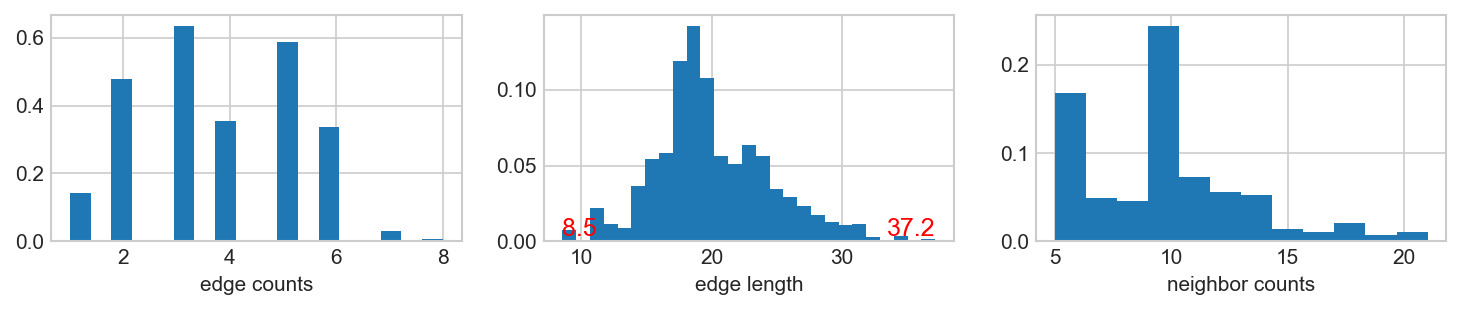

In [5]:
for part_name in part_names:
    print(f"{'-'*20}{part_name}{'-'*20}")
    in_step_file = f"{robot_folder}/{part_name}.step" # input file name
    out_msh_file = f"{robot_folder}/{part_name}.msh" # output file name for .msh
    out_stl_file = f"{robot_folder}/{part_name}.stl" # output file name for .stl
    vmesh, _ = generateGmsh(in_step_file, out_msh_file, gmsh_args=gmsh_args,
                        gmsh_args_3d=gmsh_args_3d, gui=show_gui, dim=dim)
    vmeshSummary(vmesh)
    # convert to stl
    convertStepToSTL(in_step_file,out_stl_file)
    
# in_file_name = os.path.join(robot_folder,"body.step")
# out_file_name = os.path.join(robot_folder,"body.msh")
# vmesh, _ = generateGmsh(in_file_name, out_file_name, gmsh_args=gmsh_args,
#                         gmsh_args_3d=gmsh_args_3d, gui=show_gui, dim=dim)
# vmeshSummary(vmesh)
# convertStepToSTL(in_file_name,out_file_name)

# load descritized mesh

# vertices         = 1463
# lines            = 8708
# surface triangle = 2544
mean line length   = 20.08
COM                = [-29.146   0.06    0.606]
COM norm           = 29.152


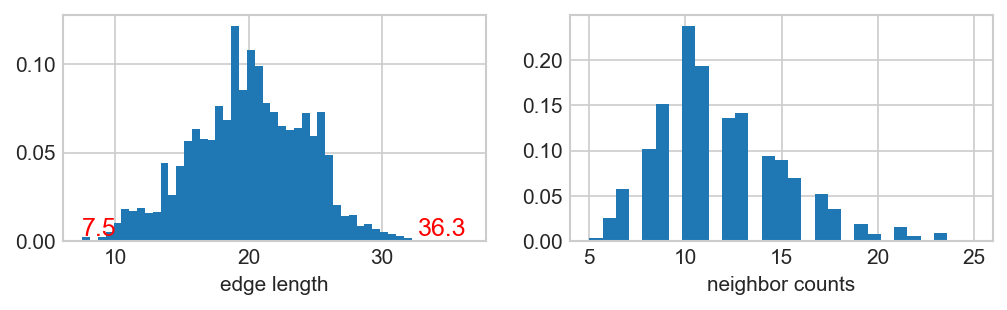

# vertices         = 161
# lines            = 896
# surface triangle = 252
mean line length   = 20.38
COM                = [65.745  0.055 -0.008]
COM norm           = 65.745


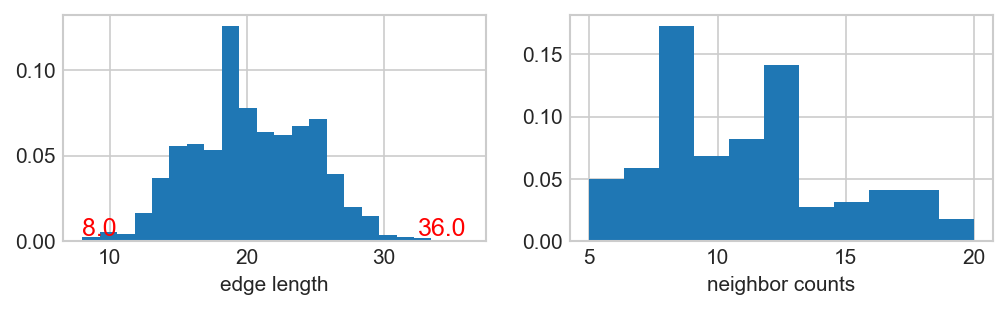

# vertices         = 221
# lines            = 1163
# surface triangle = 342
mean line length   = 20.28
COM                = [   0.628   -0.317 -115.977]
COM norm           = 115.979


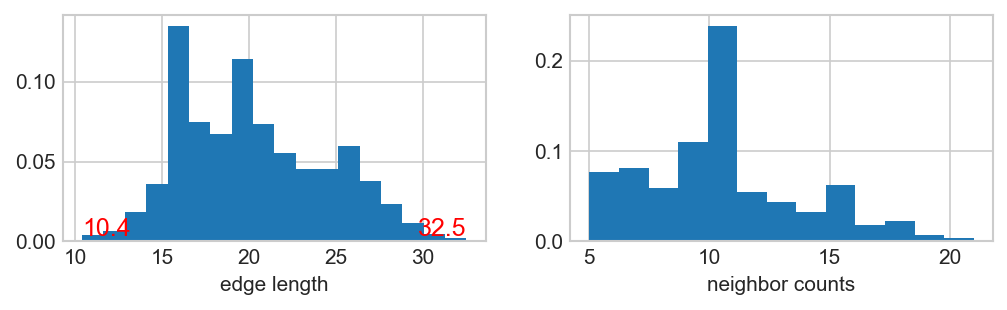

# vertices         = 157
# lines            = 794
# surface triangle = 252
mean line length   = 20.38
COM                = [ -0.263  -0.045 -99.935]
COM norm           = 99.935


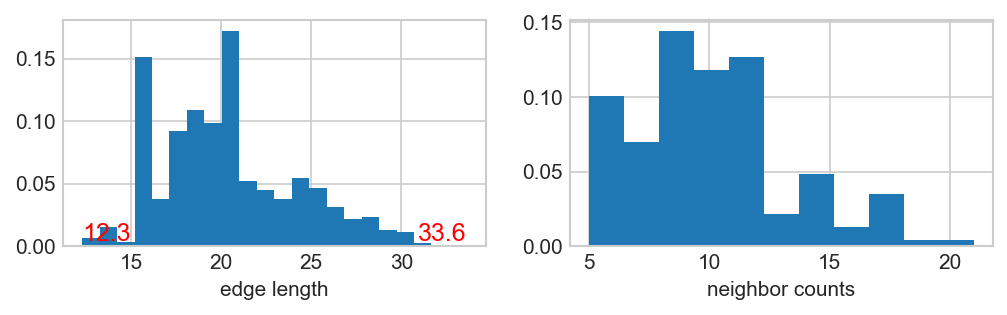

# vertices         = 215
# lines            = 1131
# surface triangle = 352
mean line length   = 20.30
COM                = [  -0.025   11.446 -109.009]
COM norm           = 109.608


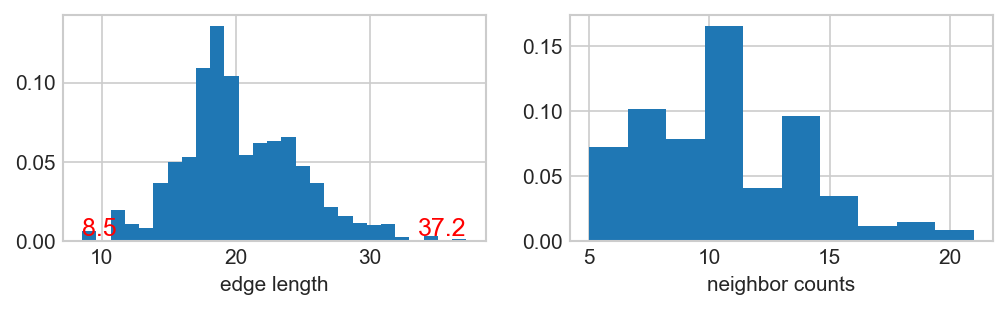

In [6]:
###############################################################
# x: back->front
# y: right->left
# z: down->top
vmd_body = VolumeMesh.fromGmsh(
    msh_file=f"{robot_folder}/{'body'}.msh",
    stl_file = f"{robot_folder}/{'body'}.stl",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4),verbose=True)

vmd_0 = VolumeMesh.fromGmsh(
    msh_file=f"{robot_folder}/{'hip'}.msh",
    stl_file = f"{robot_folder}/{'hip'}.stl",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4),verbose=True)

vmd_1 = VolumeMesh.fromGmsh(
    msh_file=f"{robot_folder}/{'thigh'}.msh",
    stl_file = f"{robot_folder}/{'thigh'}.stl",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4),verbose=True)

vmd_2f = VolumeMesh.fromGmsh(
    msh_file=f"{robot_folder}/{'shank_front'}.msh",
    stl_file = f"{robot_folder}/{'shank_front'}.stl",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4),verbose=True)

vmd_2b = VolumeMesh.fromGmsh(
    msh_file=f"{robot_folder}/{'shank_back'}.msh",
    stl_file = f"{robot_folder}/{'shank_back'}.stl",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4),verbose=True)

In [4]:
# vmd = vmd_0.copy()
# cylinder_trimesh = trimesh.creation.cylinder(10,10)
# cylinder_trimesh.show()
# scene = trimesh.scene.Scene([trimesh.creation.cylinder(10,10),trimesh.creation.cylinder(5,20)])
# scene.show()
# vmd = VolumeMesh(vmd_leg.vertices,vmd_leg.lines,vmd_leg.triangles).copy(cmap ='pink')
# o3dShow([vmd.lsd,vmd.pcd])

# Assemble the parts

In [5]:
# unit = Unit({"length":"mm","density":"g/mm^3"})
# unit.toSI("density")

In [7]:
############################ defineing joints geometry
dx_body_f0 = 70.
dy_body_f0 = 102.
dz_body_f0 = 0.

dx_f01 = 71.
dy_f01 = 0.
dz_f01 = 0.

dx_f12 = 0.
dy_f12 = 0.
dz_f12 = 143.

dx_body_b0 = 175.
dy_body_b0 = 25.
dz_body_b0 = 0.

dx_b01 = 71.
dy_b01 = 0.
dz_b01 = 0.

dx_b12 = 0.
dy_b12 = 0.
dz_b12 = 143.

tlf_body_0 = np.array([
    [0,0,1,dx_body_f0],
    [1,0,0,dy_body_f0],
    [0,1,0,dz_body_f0],
    [0,0,0,1]])# front left hip

tlf_0_1 = np.array([
    [0,0,-1,dx_f01],
    [-1,0,0,dy_f01],
    [0,1,0,dz_f01],
    [0,0,0,1]])# front left thigh 

tlf_1_2 = translation((+dx_f12,+dy_f12,-dz_f12))\
.dot(axisAngleRotation((0, 0, 1),-np.pi/2))# front left shank


trf_body_0 = np.array([
    [0, 0,1,dx_body_f0],
    [-1,0,0,-dy_body_f0],
    [0,-1,0,dz_body_f0],
    [0,0,0,1]])# front right hip

trf_0_1 = np.array([
    [0,0,-1,dx_f01],
    [1,0,0,dy_f01],
    [0,-1,0,dz_f01],
    [0,0,0,1]])# front right thigh 

trf_1_2 = translation((+dx_f12,+dy_f12,-dz_f12))\
                .dot(axisAngleRotation((0, 0, 1),np.pi/2))# front right shank

tlb_body_0 = np.array([
    [0,0,1,-dx_body_b0],
    [1,0,0,dy_body_b0],
    [0,1,0,dz_body_b0],
    [0,0,0,1]])# back left hip

tlb_0_1 = np.array([
    [0, 0,-1,dx_b01],
    [-1,0, 0,dy_b01],
    [0, 1, 0,dz_b01],
    [0,0,0,1]])# back left thigh 

tlb_1_2 = translation((+dx_b12,+dy_b12,-dz_b12))\
                .dot(axisAngleRotation((0, 0, 1),-np.pi/2))# back left shank

trb_body_0 = np.array([
    [0, 0,1,-dx_body_b0],
    [-1,0,0,-dy_body_b0],
    [0,-1,0,dz_body_b0],
    [0,0,0,1]])# back right hip

trb_0_1 = np.array([
    [0, 0,-1,dx_b01],
    [1, 0, 0,dy_b01],
    [0,-1, 0,dz_b01],
    [0,0,0,1]])# back right thigh 

trb_1_2 = translation((+dx_b12,+dy_b12,-dz_b12))\
                .dot(axisAngleRotation((0, 0, 1),np.pi/2))# back right shank

In [50]:
graph = RobotDescription(unit_dict={"length": "mm"})
graph.add_nodes_from([
    (0, {"vmd": vmd_body.copy(cmap='RdGy'), "alias": "body","color":to_rgba("r")}),  # main_body
    (1, {"vmd": vmd_0.copy(cmap='spring'), "alias": "lf_hip","color":to_rgba("g")}),  # front left
    (2, {"vmd": vmd_1.copy(cmap='spring'), "alias": "lf_thigh"}),
    (3, {"vmd": vmd_2f.copy(cmap='spring'), "alias": "lf_shank","color":to_rgba("b")}),

    (4, {"vmd": vmd_0.copy(cmap='summer'), "alias": "rf_hip","color":to_rgba("g")}),  # front right
    (5, {"vmd": vmd_1.copy(cmap='summer'), "alias": "rf_thigh"}),
    (6, {"vmd": vmd_2f.copy(cmap='summer'), "alias": "rf_shank","color":to_rgba("b")}),

    (7, {"vmd": vmd_0.copy(cmap='autumn'), "alias": "lb_hip","color":to_rgba("g")}),  # back left
    (8, {"vmd": vmd_1.copy(cmap='autumn'), "alias": "lb_thigh"}),
    (9, {"vmd": vmd_2b.copy(cmap='autumn'), "alias": "lb_shank","color":to_rgba("b")}),

    (10, {"vmd": vmd_0.copy(cmap='winter'), "alias": "rb_hip","color":to_rgba("g")}),  # back right
    (11, {"vmd": vmd_1.copy(cmap='winter'), "alias": "rb_thigh"}),
    (12, {"vmd": vmd_2b.copy(cmap='winter')\
          .transform(axisAngleRotation((0, 0, 1),np.pi))# rotate 180 deg around local z axis
        ,"alias": "rb_shank","color":to_rgba("b")}),
],
    transform=np.eye(4),
    density=176.,
    color=np.array((1, 1, 1, 1))  # white
)
#graph.nodes['body']['density'] = 100


graph.add_edges_from((
    (0, 1, {"order":0,"transform": tlf_body_0, "joint_pos": 0}),
    (1, 2, {"order":1,"transform": tlf_0_1, "joint_pos": 0}),
    (2, 3, {"order":2,"transform": tlf_1_2, "joint_pos": 0}),

    (0, 4, {"order":3,"transform": trf_body_0, "joint_pos": 0}),
    (4, 5, {"order":4,"transform": trf_0_1, "joint_pos": 0}),
    (5, 6, {"order":5,"transform": trf_1_2, "joint_pos": 0}),

    (0, 7, {"order":6,"transform": tlb_body_0, "joint_pos": 0}),
    (7, 8, {"order":7,"transform": tlb_0_1, "joint_pos": 0}),
    (8, 9, {"order":8,"transform": tlb_1_2, "joint_pos": 0}),

    (0, 10, {"order":9,"transform": trb_body_0, "joint_pos": 0}),
    (10, 11, {"order":10,"transform": trb_0_1, "joint_pos": 0}),
    (11, 12, {"order":11,"transform": trb_1_2, "joint_pos": 0}),
),
    transform=np.eye(4),
    joint_type="revolute",
    joint_pos=0,
    axis=(1, 0, 0),
    limit={  # units must be SI here
        "effort": 11,  # torque, [Nm]
        "velocity": round(487/60*2*np.pi)  # speed [rad/s]
}
)

# create coordinate in body space
graph.createCoordinateOXYZ(radius=15)
################## computed value ###################################
graph.updateWorldTransform()
# list(nx.edge_bfs(graph))

#####################################################################
for k, e in enumerate(graph.orderedEdges):
    print(f"{k}:{e}")

0:(0, 1)
1:(1, 2)
2:(2, 3)
3:(0, 4)
4:(4, 5)
5:(5, 6)
6:(0, 7)
7:(7, 8)
8:(8, 9)
9:(0, 10)
10:(10, 11)
11:(11, 12)


In [51]:
# graph.draw()

In [65]:
# graph.joint_pos = np.array([-np.pi/2,-np.pi/2,-np.pi/2,-np.pi/2])

#graph.joint_pos = np.array([7 * np.pi/4, np.pi/4, -np.pi/3, np.pi/3, 0, np.pi/3, 0, -np.pi/3, 0, 0, 0, 0])
# graph.joint_pos = np.array([4 * np.pi / 5, 4 * np.pi/3, np.pi/3, 3 * np.pi/2,\
#                             0, np.pi / 2, 0, 3 * np.pi / 2, 0, 11 * np.pi / 6, 0, np.pi / 6])

# graph.joint_pos = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# graph.joint_pos = np.array([np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 0, 0, 0, 0, 0, 0, 0, 0])

knee_angle = np.pi*0.03

arm_angle = np.pi/6
# arm_angle = 0

graph.joint_pos = np.array([
    # front left
    0,               # 0
    -np.pi/2+arm_angle,        # 1
    0,               # 2
    # front right
    0,               # 3 
    np.pi/2-arm_angle,         # 4  
    0,               # 5
    # back left
    0+knee_angle,               # 6     
    -np.pi/2,        # 7   
    0+knee_angle,               # 8
    # back right
    0-knee_angle,               # 9        
    np.pi/2,         # 10 
    0-knee_angle               # 11   
])     

graph.updateWorldTransform(t = axisAngleRotation((0, 0, 1),np.pi/2)) #TODO MAKE IT RIGHT
# graph.updateWorldTransform()

world_space_pcds = [o3d.geometry.PointCloud(graph.nodes[n]["vmd"].pcd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_lsd = [o3d.geometry.LineSet(graph.nodes[n]["vmd"].lsd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_o3dMesh = [o3d.geometry.TriangleMesh(graph.nodes[n]["vmd"].o3dMesh()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]



link_coordinate_frames = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.nodes[n]["world_transform"])for n in graph.nodes]

joint_coordiate_frams = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.edges[e]["world_transform"])for e in graph.edges]

o3dShow(world_space_pcds+world_space_lsd+link_coordinate_frames+joint_coordiate_frams + [coord_frame],background_color=(0,0,0))


###############################################
discretization_opt = dict(
    min_radius=min_radius, 
    max_radius=radius_knn, 
    max_nn=max_nn,
    joint_radius = 40.,
    joint_height = 40.,
    joint_sections = 50, # number of sections of the joint cylinder mesh
    gmsh_args=gmsh_args,
    gmsh_args_3d=gmsh_args_3d,
)


graph = graph.makeJoint(opt=discretization_opt)
#################################################

joint_cylinders = [o3d.geometry.TriangleMesh(graph.edges[e]["cylinder_parent"].o3dMesh()).transform(
    graph.nodes[e[0]]["world_transform"]) for e in graph.edges]
# o3dShow(world_space_pcds[0:]+world_space_lsd[0:]+world_space_o3dMesh[0:]+joint_cylinders[0:])#+link_coordinate_frames+joint_coordiate_frams)
# o3dShow(world_space_pcds[0:]+world_space_lsd[0:]+joint_coordiate_frams+joint_cylinders[0:],background_color=(0,0,0))#+link_coordinate_frames+joint_coordiate_frams)

# o3dShow(world_space_pcds[0:]+world_space_lsd[0:])#+link_coordinate_frames+joint_coordiate_frams)

# robot_lsd = o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(vertices),
#     o3d.utility.Vector2iVector(lines))
# robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))
# o3dShow([robot_lsd]+joint_cylinders[0:])

edge(0, 1): ((70, 70)) already processed, skipping
edge(0, 4): ((70, 70)) already processed, skipping
edge(0, 7): ((70, 70)) already processed, skipping
edge(0, 10): ((70, 70)) already processed, skipping
edge(1, 2): ((70, 70)) already processed, skipping
edge(2, 3): ((70, 70)) already processed, skipping
edge(4, 5): ((70, 70)) already processed, skipping
edge(5, 6): ((70, 70)) already processed, skipping
edge(7, 8): ((70, 70)) already processed, skipping
edge(8, 9): ((70, 70)) already processed, skipping
edge(10, 11): ((70, 70)) already processed, skipping
edge(11, 12): ((70, 70)) already processed, skipping


In [66]:
# saving
import pickle
path = robot_folder+"robot.pickle"
with open(path,"wb") as f:
    pickle.dump(graph,f)

In [67]:
# loading
import pickle
path = robot_folder+"robot.pickle"
with open(path,"rb") as f:
    graph = pickle.load(f)

# create spring-mass representation

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
{0: (0, 1), 1: (0, 4), 2: (0, 7), 3: (0, 10), 4: (1, 2), 5: (2, 3), 6: (4, 5), 7: (5, 6), 8: (7, 8), 9: (8, 9), 10: (10, 11), 11: (11, 12)}
id_vertices=[   0 1642 1910 2235 2462 2730 3055 3282 3550 3875 4160 4428 4753 5038
 5062 5237]
id_vertices labels:
(0, 0)
(1, 1642)
(2, 1910)
(3, 2235)
(4, 2462)
(5, 2730)
(6, 3055)
(7, 3282)
(8, 3550)
(9, 3875)
(10, 4160)
(11, 4428)
(12, 4753)
('anchor', 5038)
('coord', 5062)
('end', 5237)
--------------------
id_lines=[    0 11561 13476 15434 16609 18520 20471 21646 23561 25522 27059 28970
 30921 32458 32470 35830 52393 52918 57293]
id_lines labels:
((0, 1), 0)
((1, 2), 11561)
((2, 3), 13476)
((0, 4), 15434)
((4, 5), 16609)
((5, 6), 18520)
((0, 7), 20471)
((7, 8), 21646)
((8, 9), 23561)
((0, 10), 25522)
((10, 11), 27059)
((11, 12), 28970)
('anchor_lines', 32458)
('rot_springs', 32470)
('fri_springs', 35830)
('coord_self_lines', 52393)
('coord_attach_lines', 52918

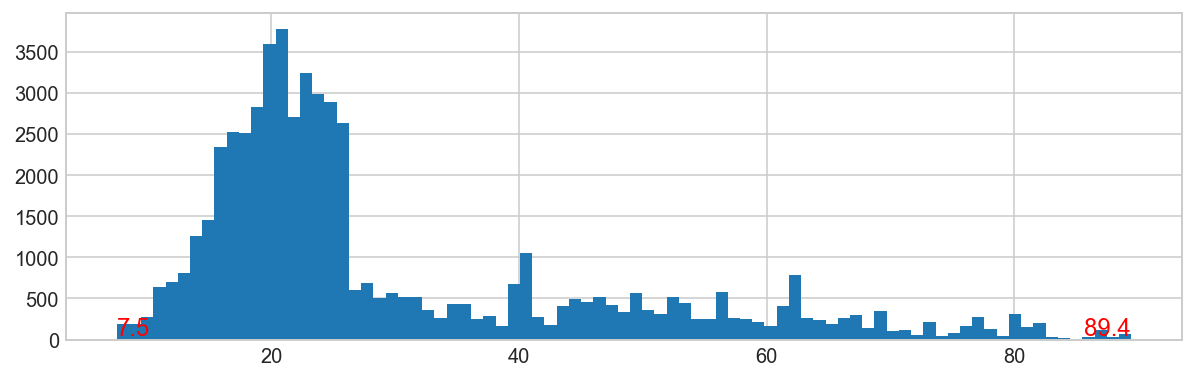

In [68]:
# number of attachment lines per point in the attached coordinates
num_attach_per_coord = 25

######################################################################
dict_id2node = dict(enumerate(graph.nodes)) # dict of index to node
dict_node2id = dict(zip(graph.nodes, range(len(graph.nodes)))) # dict of node to index
print(dict_id2node)
dict_id2edge = dict(enumerate(graph.edges)) # dict of index to edges
dict_edge2id = dict(zip(graph.edges, range(len(graph.edges))))
print(dict_id2edge)


graph.updateWorldTransform()

# ##################################################
part_vertices = [applyTransform(graph.nodes[n]["vmd"].vertices,
                                graph.nodes[n]["world_transform"]) for n in graph.nodes]
anchor_vertices = [applyTransform(graph.edges[e]['anchor'],
                                  graph.edges[e]["world_transform"]) for e in graph.orderedEdges]
part_coord_vertices = [applyTransform(graph.nodes[n]['coord'],
                                      graph.nodes[n]["world_transform"]) for n in graph.nodes]
joint_coord_vertices = [applyTransform(graph.edges[e]['coord'],
                                       graph.edges[e]["world_transform"]) for e in graph.orderedEdges]

# vertices:
# parts_xyzs = part_k_xyzs for k in range(#nodes)
# anchors_xyzs = anchor_k for k in range(#joints)
# coord_xys = coord(root_node), coord(joint_k_left),coord(joint_k_right), k in range(#joints)
# vertices = np.vstack(part_vertices + 
#                      anchor_vertices +
#                      part_coord_vertices + 
#                      joint_coord_vertices)

vertices = part_vertices + \
    [np.vstack(anchor_vertices)] +\
    [np.vstack(part_coord_vertices+joint_coord_vertices)]
id_vertices = np.hstack(([0], np.cumsum([len(v) for v in vertices])))
vertices = np.vstack(vertices)

id_vertices_label = [(n, id_vertices[k]) for k, n in enumerate(graph.nodes)] + \
    [("anchor", id_vertices[len(graph)]),
     ("coord", id_vertices[len(graph)+1]),
     ("end", id_vertices[len(graph)+2])]

# colors of the vertices
part_colors = np.vstack(
    [graph.nodes[n]["vmd"]["vertices_color"] for n in graph.nodes])
colors = np.zeros((len(vertices), 3))
colors[:len(part_colors)] = part_colors


###################################################################
part_len = [len(v) for v in part_vertices]
anchor_len = [len(v) for v in anchor_vertices]
part_coord_len = [len(v) for v in part_coord_vertices]
joint_coord_len = [len(v) for v in joint_coord_vertices]

# id_vertices = np.hstack(
#     ([0], np.cumsum(part_len+anchor_len+part_coord_len+joint_coord_len)))

# vertex ids
vid_part = np.hstack(([0], np.cumsum(part_len)))  # vertex id part
vid_anchor = np.hstack(([0], np.cumsum(anchor_len))) + \
    vid_part[-1]  # vertex id anchor
vid_part_coord = np.hstack(([0], np.cumsum(part_coord_len))) + vid_anchor[-1]
vid_joint_coord = np.hstack(
    ([0], np.cumsum(joint_coord_len))) + vid_part_coord[-1]

for k, n in enumerate(graph.nodes):
    graph.nodes[n]["vertex_start_id"] = vid_part[k]
    graph.nodes[n]["coord_start_id"] = vid_part_coord[k]
for k, e in enumerate(graph.orderedEdges):
    graph.edges[e]["coord_start_id"] = vid_joint_coord[k]
    graph.edges[e]["anchor_start_id"] = vid_anchor[k]
############################################################
# part surfaces
part_surface_id = np.hstack(
    [np.unique(graph.nodes[n]["vmd"]["triangles"].ravel()) +
     graph.nodes[n]["vertex_start_id"] for n in graph.nodes])
is_surface = np.zeros(len(vertices), dtype=bool)
is_surface[part_surface_id] = True

###############################################################
part_triangles = [graph.nodes[n]["vmd"].triangles +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

triangles = np.vstack(part_triangles)
###############################################################
part_lines = [graph.nodes[n]["vmd"].lines +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

anchor_lines = [(graph.edges[e]["anchor_start_id"],
                 graph.edges[e]["anchor_start_id"]+1) for e in graph.orderedEdges]

part_coord_self_lines = [graph.nodes[n]["coord_start_id"] +
                         graph.nodes[n]["coord_self_lines"] for n in graph.nodes]
joint_coord_self_lines = [graph.edges[e]["coord_start_id"] +
                          graph.edges[e]["coord_self_lines"] for e in graph.orderedEdges]


# connecting coordinate to the body parts
part_coord_attach_lines = []
for k, n in enumerate(graph.nodes):
    part_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[k],
                  right_vertices=part_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[k],
                  right_id_start=vid_part_coord[k]))

# connecting coordinate to the joint-parent
joint_coord_attach_lines = []
for k, e in enumerate(graph.orderedEdges):
    parent_id = dict_node2id[e[0]]
    joint_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[parent_id],  # parent vertices
                  right_vertices=joint_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[parent_id],
                  right_id_start=vid_joint_coord[k]))


joints = []

for k, e in enumerate(graph.orderedEdges):
    edge = graph.edges[e]
    parent = e[0]
    child = e[1]
    parent_id = dict_node2id[e[0]]
    child_id = dict_node2id[e[1]]
    joint_k = Joint(
        left=edge["id_joint_parent"]+vid_part[parent_id],
        right=edge["id_joint_child"]+vid_part[child_id],
        anchor=anchor_lines[k],
        left_coord=edge["coord_start_id"],
        right_coord=graph.nodes[child]["coord_start_id"],
        axis=edge["axis"]
    )
    lines_length = np.linalg.norm(vertices[joint_k.friSpring[:, 0]] -
                                  vertices[joint_k.friSpring[:, 1]], axis=1)
    joint_k.friSpring = joint_k.friSpring[lines_length > 0.3*radius_knn]
    joints.append(joint_k)

rot_springs = [j.rotSpring for j in joints]
fri_springs = [j.friSpring for j in joints]

# lines:
# parts_lines = part_k_lines for k in range(#nodes)
# anchors_lines
# oxyz_self_springs
# oxyz_anchor_springs
# rotation springs
# resetable friction springs

coord_self_lines = part_coord_self_lines+joint_coord_self_lines
coord_attach_lines = part_coord_attach_lines+joint_coord_attach_lines

lines = part_lines +\
    [np.vstack(anchor_lines)] +\
    [np.vstack(rot_springs)] +\
    [np.vstack(fri_springs)] +\
    [np.vstack(coord_self_lines)] +\
    [np.vstack(coord_attach_lines)]

# start, end of respective lines
id_lines = np.hstack(([0], np.cumsum([len(v) for v in lines])))

lines = np.vstack(lines)

# whether the springs has surface end-points
lines_is_surface = np.bitwise_or.reduce(np.isin(lines,part_surface_id),1)

id_lines_label = [(n, id_lines[k]) for k, n in enumerate(graph.orderedEdges)] + \
    [("anchor_lines", id_lines[len(graph)]),
     ("rot_springs", id_lines[len(graph)+1]),
     ("fri_springs", id_lines[len(graph)+2]),
     ("coord_self_lines", id_lines[len(graph)+3]),
     ("coord_attach_lines", id_lines[len(graph)+4]),
     ("end", id_lines[len(graph)+5])]

print(f"id_vertices={id_vertices}")
print("id_vertices labels:",*id_vertices_label,"-"*20, sep = "\n")

print(f"id_lines={id_lines}")
print("id_lines labels:",*id_lines_label,"-"*20, sep = "\n")

lines_length = np.linalg.norm(vertices[lines[:,0]] - vertices[lines[:,1]],axis=1)
plt.figure(figsize=(10,3))
n,bins,_ =plt.hist(lines_length,bins="auto")
plt.text(bins[0],0,f"{bins[0]:.1f}",ha="left",va="bottom",fontsize="large",color='r')
plt.text(bins[-1],0,f"{bins[-1]:.1f}",ha="right",va="bottom",fontsize="large",color='r')

plt.show()

In [69]:
robot_lsd = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(applyTransform(
        vertices,axisAngleRotation((0, 1, 0),np.pi*7/8)@axisAngleRotation((0, 0, 1),np.pi/2))),
    o3d.utility.Vector2iVector(lines))
robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))


############# check surface springs #############
# robot_lsd.paint_uniform_color((1,1,1))
# colors = np.asarray(robot_lsd.colors)
# colors[lines_is_surface] = (0.2,0.2,0.2)
# robot_lsd.colors = o3d.utility.Vector3dVector(colors)
#######################################################
# robot_lsd.paint_uniform_color((0.1,0.1,0.1))
# num_body = len(graph.nodes)
# step = id_lines[num_body]//128
# colors = np.asarray(robot_lsd.colors)
# colors[range(0,id_lines[num_body],step)] = (1,1,1)
# robot_lsd.colors = o3d.utility.Vector3dVector(colors)


o3dShow([robot_lsd],background_color=(0,0,0))

In [70]:
# o3dShow(robot_lsd)
# export
xyz_all_trans = vertices.copy()

xyz_all_trans = applyTransform(xyz_all_trans,axisAngleRotation((0, 1, 0),-np.pi/2))

min_bound = xyz_all_trans.min(axis=0)
# transoformed ofset scaled mm->m
xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]+-1]))/1000


joints_list = [joint.toDict() for joint in joints]
data = {
    "radius_poisson":radius_poisson*1e-3,# convert to m
    "vertices":xyz_all_trans.tolist(),
    "edges":lines.tolist(),
    "triangles":triangles.tolist(),
    "isSurface":is_surface.tolist(),
    "idVertices":id_vertices.tolist(),
    "idEdges":id_lines.tolist(),
    "colors":colors.tolist(),
    "joints":joints_list,
    "isSurfaceEdges":lines_is_surface.tolist() # surface lines
}



print(xyz_all_trans.min(axis=0))
print(xyz_all_trans.max(axis=0))
print(xyz_all_trans.shape)
print(lines.shape)


# robot_lsd = o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(xyz_all_trans),
#     o3d.utility.Vector2iVector(lines))
# robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))
# o3dShow([robot_lsd,o3d.geometry.TriangleMesh.create_coordinate_frame(
#     size=0.1, origin=[0, 0, 0])])

# https://stackoverflow.com/questions/43442194/how-do-i-read-and-write-with-msgpack
# Write msgpack file
with open('../flexipod_12dof.msgpack', 'wb') as outfile:
    msgpack.pack(data, outfile)
    
# # Read msgpack file
# with open('../data.msgpack','rb') as data_file:
#     # data_loaded = json.load(data_file)
#     data_loaded = msgpack.unpack(data_file)

[-0.06145749 -0.35048076 -0.001     ]
[0.07654251 0.35048076 0.59836536]
(5237, 3)
(57293, 2)


In [58]:
# # Read msgpack file
# with open('../flexipod_12dof.msgpack','rb') as data_file:
#     # data_loaded = json.load(data_file)
#     data_loaded = msgpack.unpack(data_file)
# # data_loaded

##  generate URDF

In [40]:
urdf_path = "../../data/urdf/test/robot.urdf"
graph.exportURDF(path= urdf_path,use_fine_mesh=True)

URDF path:D:\repo\FlexipodFast\data\urdf\test\robot.urdf

<?xml version='1.0' encoding='ASCII'?>
<robot name="robot">
  <link name="0">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="0.6619871640245176"/>
      <inertia ixx="0.002780827859687883" ixy="1.3747788133504628e-08" ixz="-9.362594391710892e-06" iyy="0.007819957582371058" iyz="1.868969568122951e-10" izz="0.009474915404544247"/>
    </inertial>
    <visual>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/0.obj"/>
      </geometry>
      <material name="#ff0000ff">
        <color rgba="1.0 0.0 0.0 1"/>
      </material>
    </visual>
    <collision>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/0.obj"/>
      </geometry>
    </collision>
  </link>
  <link name="1">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="0.07174383694960038"/>
      <inertia ixx=

In [38]:
import numpy as np
import pybullet as p
import time
import pybullet_data
##########################################
urdf_path = "../../data/urdf/test/robot.urdf"
####################################################

gui = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=gui)
p.setGravity(0, 0, -10)
robot_id = p.loadURDF(urdf_path, [0, 0, 0.5], physicsClientId=gui)
plane = p.loadURDF("plane.urdf")
   
# # # ##################################################
# while (p.getConnectionInfo(physicsClientId=gui)["isConnected"]):
#     #p.setJointMotorControlArray(robot_id,np.arange(p.getNumJoints(robot_id)),p.POSITION_CONTROL,joint_pos)
#     p.stepSimulation(physicsClientId=gui)
#     #time.sleep(0.01)
    
# p.disconnect()

In [39]:
from scipy.spatial.transform import Rotation
#################################################################
joint_pos = np.array([
    # front left
    0,               # 0
    -np.pi/2,        # 1
    0,               # 2
    # front right
    0,               # 3 
    np.pi/2,         # 4  
    0,               # 5
    # back left
    0,               # 6     
    -np.pi/2,        # 7   
    0,               # 8
    # back right
    0,               # 9        
    np.pi/2,         # 10 
    0                # 11   
]) 
dof = len(joint_pos)
for k in range(dof):
    p.resetJointState(robot_id, k, targetValue=joint_pos[k])
    
quat = Rotation.from_euler('xyz',[0,-np.pi/2,0]).as_quat()
p.resetBasePositionAndOrientation(robot_id, [0, 0, 0.5], quat)

p.setJointMotorControlArray(robot_id, list(range(dof)), controlMode= p.POSITION_CONTROL,
                                    targetPositions=joint_pos)
for k in range(1000):
    p.stepSimulation(physicsClientId=gui)

In [41]:
p.disconnect()

In [22]:
# p.getNumJoints(robot_id)